In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.xception import Xception
from random import shuffle
import os
import cv2
from glob import glob

### Визуализируем примеры для обучения

In [3]:
train_files = glob('./train/*.jpg')
test_files = glob('./test/*.jpg')

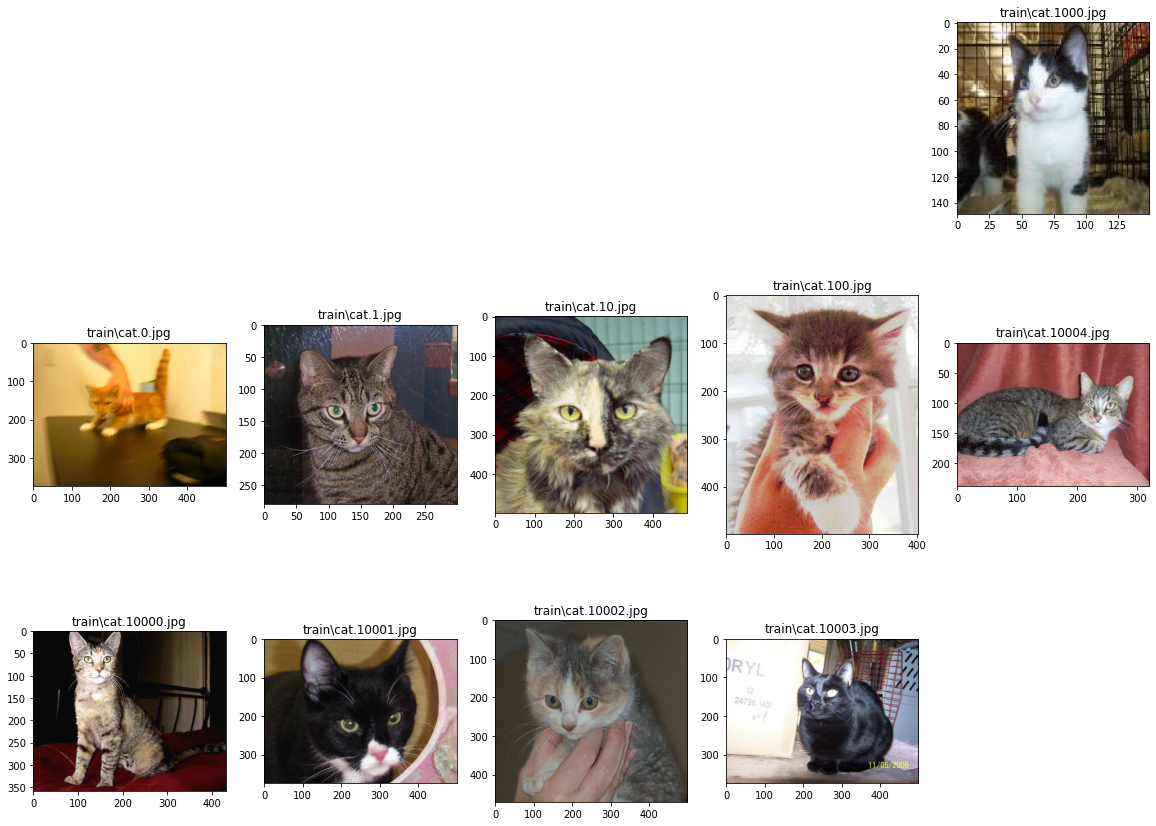

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

### Загрузка данных для работы

In [5]:
TRAIN_DIR = './train/'
TEST_DIR = './test/'

#### Ограничения на количество файлов в выборке

In [6]:
n_file = 1000

#### Размер валидационной выборки

In [7]:
n_file_val = int(n_file * 0.2)

In [8]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)][:n_file]
IMG_SIZE = (224, 224)

### Перемешивание тренировочных данных

In [9]:
shuffle(train_images)

### Разметка целевого признака по слову в файле

In [10]:
labels=[]

for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

### Функция считывание картинки и подгонка под единый размер

In [11]:
def read_image(file_path):
    im_cv = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE  #IMREAD_COLOR
    img = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)

### Функция подготовки данных для модели

In [12]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, 224, 224, 3), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
            
    return data

#### Подготовка тренировочных данных

In [13]:
%%time

train = prep_data(train_images[:n_file])

Wall time: 1.64 s


In [14]:
train.shape

(1000, 224, 224, 3)

#### Случайная картинка из тренировочной выборки

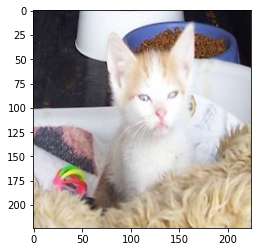

In [15]:
plt.imshow(train[25]);

#### Установка меток

In [16]:
y_train = np.array(labels[:n_file])

### Загружаем предобученную модель

In [17]:
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [18]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [19]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Добавляем полносвязный слой

In [20]:
#x = base_model.layers[-5].output
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

### Выводим архитектуру модели

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Компилируем модель и запускаем обучение

In [22]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy
              metrics=['accuracy'])

In [23]:
%%time

model.fit(train[:(n_file - n_file_val)], y_train[:(n_file - n_file_val)], epochs=3, batch_size=32)

Epoch 1/3
25/25 [==============================] - 16s 220ms/step - loss: 3.2113 - accuracy: 0.7989
Epoch 2/3
25/25 [==============================] - 6s 220ms/step - loss: 0.2154 - accuracy: 0.9795
Epoch 3/3
25/25 [==============================] - 6s 221ms/step - loss: 0.0670 - accuracy: 0.9960
Wall time: 27.6 s


### Подготовка тестовых данных

In [24]:
%%time

test = prep_data(test_images)

Wall time: 1.62 s


#### Случайная тестовая картинка

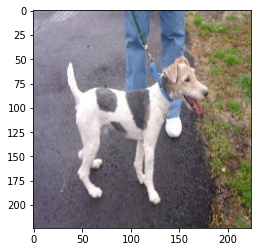

In [25]:
plt.imshow(test[55]);

### Предсказания по тестовой выборке

In [26]:
pred = model.predict(test, batch_size=32, verbose=1)

32/32 [==============================] - 10s 305ms/step


### Случайные картики и результат предсказания по ним

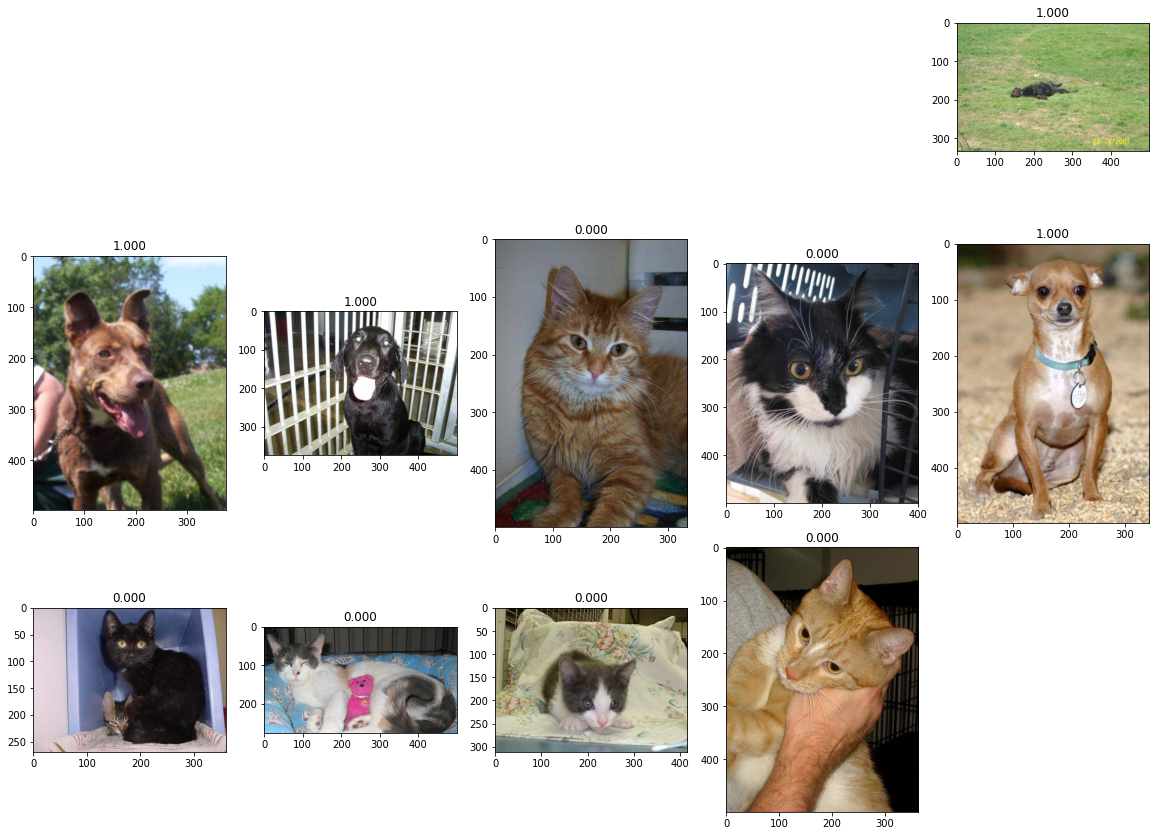

In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

In [28]:
%%time

print("train set :", model.evaluate(train[:(n_file - n_file_val)], y_train[:(n_file - n_file_val)], 
                                    verbose=True,batch_size=1)[1]*100, "%")
print("---------------------------")
print("valid set :", model.evaluate(train[(n_file - n_file_val):], y_train[(n_file - n_file_val):], 
                                    verbose=True,batch_size=1)[1]*100, "%")
print("---------------------------")

800/800 [==============================] - 18s 22ms/step - loss: 0.0550 - accuracy: 0.9975
train set : 99.75000023841858 %
---------------------------
200/200 [==============================] - 4s 22ms/step - loss: 0.8469 - accuracy: 0.9700
valid set : 97.00000286102295 %
---------------------------
Wall time: 22.3 s


### Предсказание для отдельного фото

In [33]:
#Номер фото из тестового набора
N_pred = 15

На фото собака


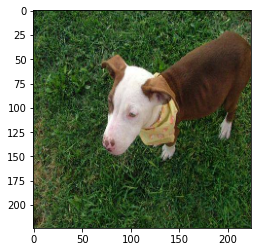

In [34]:
pred = model.predict(test[N_pred:(N_pred+1):1],batch_size=32)
if pred[0] == 1:
    print('На фото собака')
else: 
    print('На фото кот') 
plt.imshow(test[N_pred]);

In [31]:
# Сохранить всю модель в  HDF5 файл
#model.save('my_model.h5')

In [32]:
# Восстановить в точности ту же модель, включая веса и оптимизатор
#new_model = keras.models.load_model('my_model.h5')